In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
import torch.optim as optim
from utils.visualize_predictions import visualize_predictions
from utils.plot_training_validation import plot_training_validation
from utils.evaluation import evaluate_model
from utils.train import train_model
from utils.load_model_weights import load_model_weights

c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_of_classes = 2
merged_dataset_dir = "../{}_classes_merged_dataset".format(num_of_classes)
save_model_path = "../saved_models/{}/vit".format(num_of_classes)


img_size = 224
batch_size = 32
num_workers = 8  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42  
num_epochs = 10
torch.manual_seed(seed)

In [3]:
# -------------------------------
# 2) DEFINICJA TRANSFORMACJI DANYCH
# -------------------------------

# Transformacje dla zestawu treningowego
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),  # Normalizacja specyficzna dla ViT
                         std=(0.5, 0.5, 0.5))
])

# Transformacje dla zestawów walidacyjnego i testowego
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])


In [4]:
# -------------------------------
# 3) ŁADOWANIE I PODZIAŁ DANYCH
# -------------------------------

# Ładowanie całego zestawu danych za pomocą ImageFolder
full_dataset = datasets.ImageFolder(root=merged_dataset_dir, transform=train_transform)

# Definicja proporcji podziału
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Obliczanie rozmiarów poszczególnych zestawów
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Zapewnia, że wszystkie próbki są użyte

# Podział zestawu danych
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)  # Zapewnia replikowalność podziału
)

# Zastosowanie różnych transformacji do zestawów walidacyjnego i testowego
# Ponieważ random_split zwraca obiekty Subset, redefiniujemy je z nowymi transformacjami
val_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    val_dataset.indices
)

test_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    test_dataset.indices
)

# Tworzenie DataLoaderów dla każdego podzbioru
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle dla treningu
    num_workers=num_workers,
    pin_memory=True  # Przyspiesza transfer danych na GPU, jeśli używasz CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Brak shuffle dla walidacji
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Brak shuffle dla testowania
    num_workers=num_workers,
    pin_memory=True
)

# Opcjonalnie: Wydrukowanie rozmiarów zestawów danych dla weryfikacji
print(f"\nTotal samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 3166
Training samples: 2532
Validation samples: 316
Test samples: 318


- Nazwa modelu: vit_base_patch16_224
- Liczba parametrów: około 86 milionów (86M)
- Rozmiar obrazu wejściowego: 224x224 pikseli
- Wielkość paczki (patch): 16x16 pikseli
- Liczba warstw (Transformer blocks): 12
- Liczba głowic w mechanizmie Attention: 12
- Wymiar wewnętrzny osadzeń (embedding size): 768
- Ukryty rozmiar w MLP (Multilayer Perceptron Head): 3072
- Dropout: Standardowo 0.1 (można zmieniać podczas dostrajania)
- Aktywacja: GELU (Gaussian Error Linear Unit)

In [5]:
# -------------------------------
# 4) DEFINICJA MODELU VISION TRANSFORMER
# -------------------------------

# Inicjalizacja pretrenowanego modelu Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Zamiana warstwy klasyfikacyjnej, aby dopasować liczbę klas w Twoim problemie
num_classes = len(full_dataset.classes)
model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.head.in_features, num_classes)
).to(device)

# Przeniesienie modelu na urządzenie (GPU lub CPU)
model = model.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip=1.0,
    print_interval=10,
    save_dir=save_model_path,
    save_best=True,
    save_every_epoch=False,
)


Epoch 1/10 - Rozpoczynam trening:


Trening:   0%|          | 0/80 [00:00<?, ?it/s]c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\vision_transformer.py:93: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Epoch 1: Train Loss: 0.6130 | Train Acc: 70.50%
Epoch 1 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:35<00:00,  1.67s/it]

Walidacja: Batch 10/10, Loss: 0.2696


c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Val Loss: 0.4902 | Val Acc: 77.53%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Epoch 2/10 - Rozpoczynam trening:


Epoch 2: Train Loss: 0.3007 | Train Acc: 88.55%
Epoch 2 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:33<00:00,  1.01s/it]

Walidacja: Batch 10/10, Loss: 0.1276


Epoch 2: Val Loss: 0.2070 | Val Acc: 92.09%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Epoch 3/10 - Rozpoczynam trening:


Epoch 3: Train Loss: 0.2551 | Train Acc: 91.27%
Epoch 3 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:32<00:00,  1.01it/s]

Walidacja: Batch 10/10, Loss: 0.4255


Epoch 3: Val Loss: 0.5961 | Val Acc: 85.13%

Epoch 4/10 - Rozpoczynam trening:


Epoch 4: Train Loss: 0.2656 | Train Acc: 91.39%
Epoch 4 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.09it/s]

Walidacja: Batch 10/10, Loss: 0.0673


Epoch 4: Val Loss: 0.1781 | Val Acc: 93.35%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Epoch 5/10 - Rozpoczynam trening:


Epoch 5: Train Loss: 0.2021 | Train Acc: 93.21%
Epoch 5 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.09it/s]

Walidacja: Batch 10/10, Loss: 0.4951


Epoch 5: Val Loss: 0.6366 | Val Acc: 83.86%

Epoch 6/10 - Rozpoczynam trening:


Epoch 6: Train Loss: 0.1840 | Train Acc: 93.33%
Epoch 6 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.08it/s]

Walidacja: Batch 10/10, Loss: 0.0730


Epoch 6: Val Loss: 0.1671 | Val Acc: 94.94%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Epoch 7/10 - Rozpoczynam trening:


Epoch 7: Train Loss: 0.1771 | Train Acc: 93.48%
Epoch 7 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.08it/s]

Walidacja: Batch 10/10, Loss: 0.0711


Epoch 7: Val Loss: 0.1702 | Val Acc: 94.30%

Epoch 8/10 - Rozpoczynam trening:


Epoch 8: Train Loss: 0.1649 | Train Acc: 94.08%
Epoch 8 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.08it/s]

Walidacja: Batch 10/10, Loss: 0.2160


Epoch 8: Val Loss: 0.4183 | Val Acc: 87.03%

Epoch 9/10 - Rozpoczynam trening:


Epoch 9: Train Loss: 0.1572 | Train Acc: 94.43%
Epoch 9 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:26<00:00,  1.09it/s]

Walidacja: Batch 10/10, Loss: 0.0454


Epoch 9: Val Loss: 0.1271 | Val Acc: 95.25%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Epoch 10/10 - Rozpoczynam trening:


Epoch 10: Train Loss: 0.1576 | Train Acc: 93.72%
Epoch 10 - Rozpoczynam walidację:


Walidacja: 100%|██████████| 10/10 [00:27<00:00,  1.09it/s]

Walidacja: Batch 10/10, Loss: 0.0133


Epoch 10: Val Loss: 0.1195 | Val Acc: 96.52%
Najlepszy model zapisany: ../saved_models/2/vit\best_model.pth

Trening zakończony.


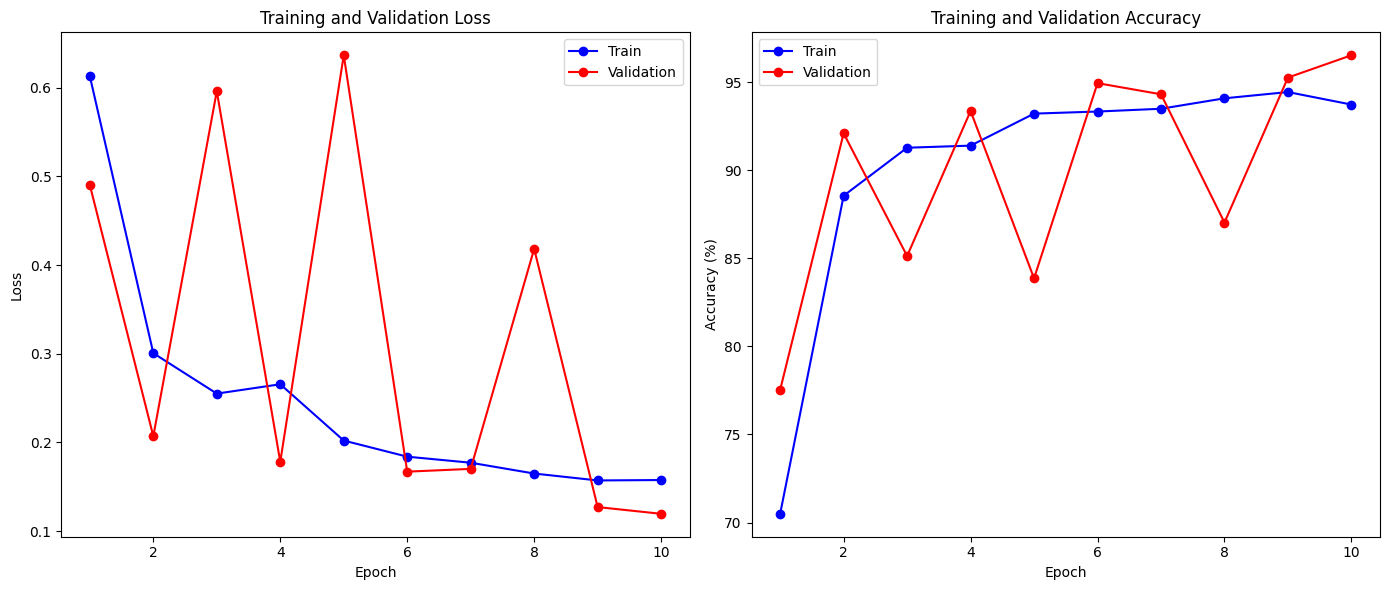

In [8]:
plot_training_validation(
    history["train_loss"], history["val_loss"], history["train_acc"], history["val_acc"]
)

In [9]:
# Optional
model = load_model_weights(model, save_model_path, device)

c:\Users\kubia\OneDrive\Pulpit\studia\uczenie głębokie\src\utils\load_model_weights.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path

Model weights loaded successfully from ../saved_models/2/vit\best_model.pth



Test Loss: 0.1427 | Test Accuracy: 0.9403



Raport klasyfikacji:
               precision    recall  f1-score   support

      NORMAL       0.95      0.93      0.94       159
   PNEUMONIA       0.93      0.95      0.94       159

    accuracy                           0.94       318
   macro avg       0.94      0.94      0.94       318
weighted avg       0.94      0.94      0.94       318


Macierz konfuzji:
[[148  11]
 [  8 151]]


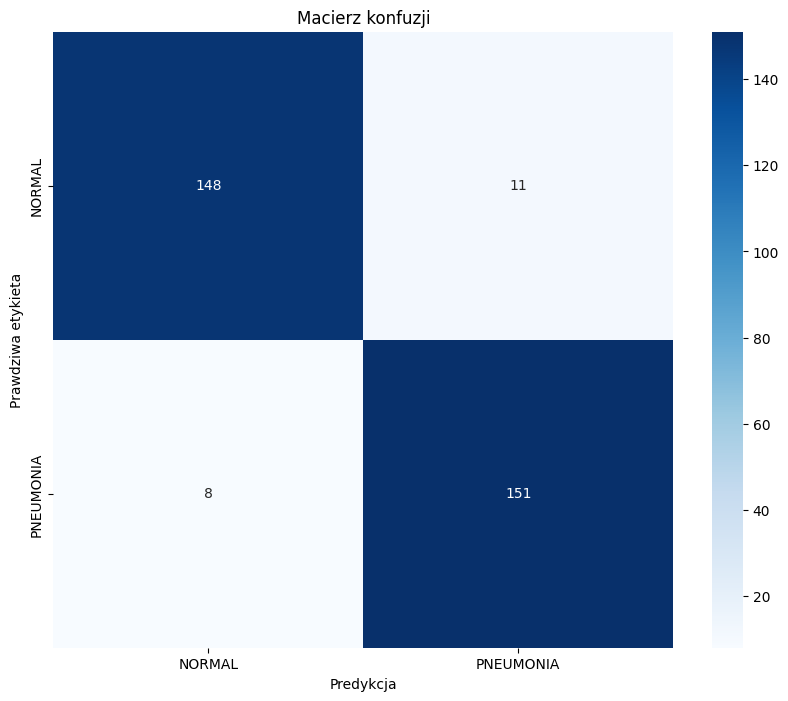

In [10]:
class_names = test_dataset.dataset.classes
evaluate_model(model, test_loader, criterion, device, class_names)

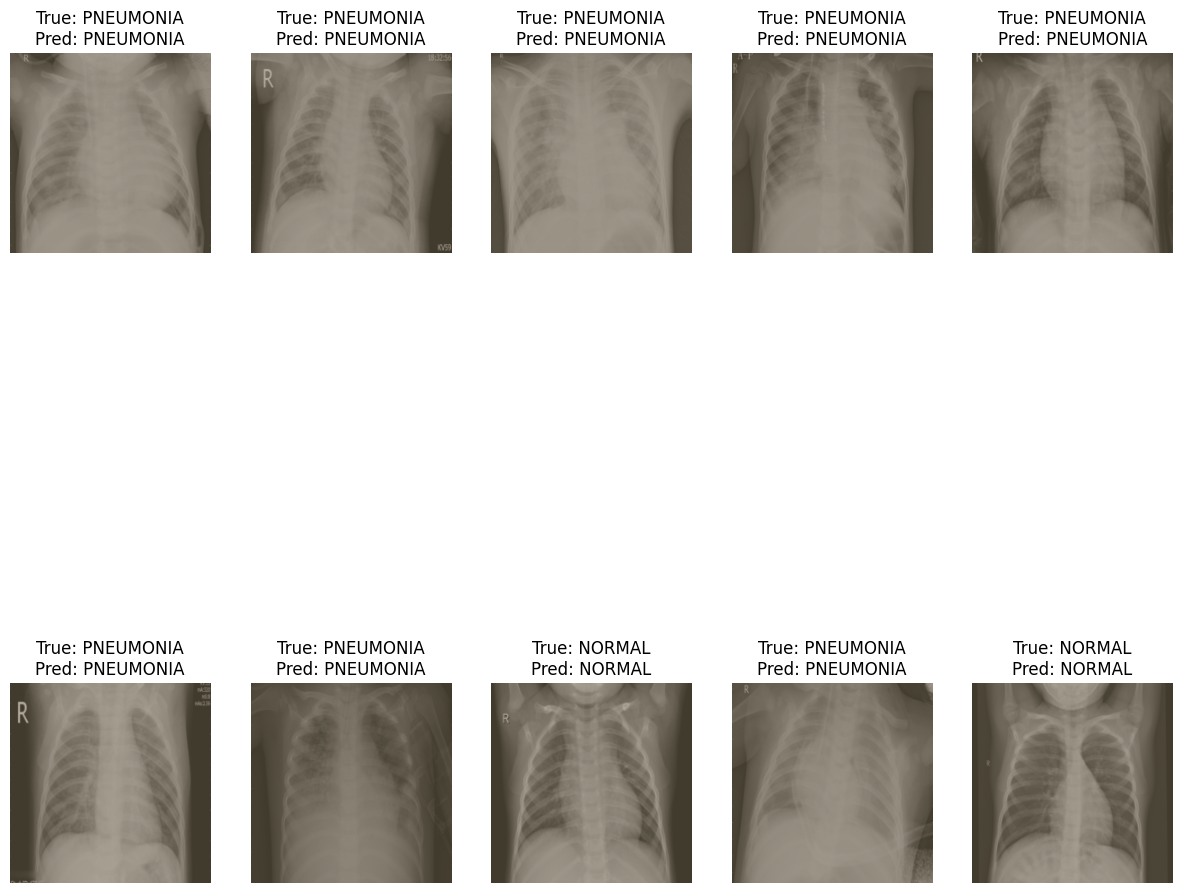

In [11]:
visualize_predictions(model, test_loader, class_names, device, num_images=10)